In [1]:
# 處理 array
import numpy as np
# 產生隨機 list，用於隨機產生出一組合法解
import random
# 畫收斂圖
import matplotlib.pyplot as plt

In [2]:
# http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/eil51.tsp
# 讀檔初始化函数
def readFile():   
    
    xy = []
    
    file = open('ei151.txt', 'r')
    r = file.read()
    
    # 每行依序讀
    read_line = r.split('\n')               
    for i in range(len(read_line)):
        # 每行再以空格切割資料
        read_element = read_line[i].split()
        # 第一個 element 當 key 第二、三個當 value
        xy.append([int(read_element[1]),int(read_element[2])])

    file.close()
    
    return np.array(xy,dtype=np.int8)

# print(coordinate)
# print(coordinate[1])
# print(len(coordinate))

In [3]:
def getDistance(arr1,arr2):
    #Euclidean distance
    x = np.power(arr1[0]-arr2[0],2)
    y = np.power(arr1[1]-arr2[1],2)
    return np.sqrt(x+y)

In [4]:
# STEP2 計算候選點清單的合適度。依照能見度(visibility)及費洛蒙(pheromone)計算合適度 fitness (公式 8.1)
def solutionConstruction(current_cityID, candidates_list, current_path):
    # 計算選定點到其他點的 fitness
    # select best from candiate

    # print("1 candidates_list:",candidates_list)
    
    for t in range(1,city_num-1):
        fitness_list = []
        for next_cityID in candidates_list:
            fitness = pow(pheromone_table[current_cityID][next_cityID],alpha)*\
                    pow(distance_table[current_cityID][next_cityID],beta)
            fitness_list.append(fitness)
            
        # 可能路徑加總
        sum_fitness = sum(fitness_list)
        transition_probability = [fitness/sum_fitness for fitness in fitness_list]
        # print(transition_probability)
        
        # STEP3 使用輪盤法挑選本次欲踏訪點 rouletteWheelSelection
        # 依 STEP2 算出的機率，ramdom 輪盤射飛鏢 找下一個拜訪點
        next_cityID = np.random.choice(candidates_list, p=transition_probability)
        # print("next_cityID",next_cityID)
        # 將下個選中拜訪點移出候選名單
        candidates_list.remove(next_cityID)
        current_path[t] = next_cityID
        current_cityID = next_cityID
        
    # 剩最後一點可拜訪直接 pop出拜訪    
    current_path[-1] = candidates_list.pop()

    return current_path
            

In [5]:
def oneAntSolution():
    
    # 候選城市清單 初始含全部點
    candidates_list = [i for i in range(city_num)] 
    # STEP1 隨機挑選起始點
    current_cityID = random.choice(candidates_list)
    # print("current_cityID",current_cityID)
    # 移除拜訪過的點，避免重複走過 like tabu list
    candidates_list.remove(current_cityID)
    
    # 儲存當前螞蟻的路徑
    current_path = np.zeros(city_num, dtype=int)
    # 設好第一站起始點
    current_path[0] = current_cityID
    
    # STEP2 計算候選點清單的合適度。依照能見度(visibility)及費洛蒙(pheromone)計算合適度
    current_path = solutionConstruction(current_cityID, candidates_list, current_path)
    
    return current_path
# current_path = oneAntSolution()
# total_distance = Evaluation(current_path)
# print("current_path",current_path)
# print("total_distance",total_distance)

In [6]:
# Evaluation: 評估一個或多個解 目標值(Objective value)大小: 行徑總距離
def Evaluation(current_path):
    total_distance = 0
    for i in range(len(current_path)):
        city1 = current_path[i]
        city2 = current_path[i+1] if i<len(current_path)-1 else current_path[0]
        total_distance += getDistance(coordinate[city1],coordinate[city2])
    return total_distance

In [7]:
# 更新費洛蒙:費洛蒙會隨時間蒸散
def pheromoneUpdate(pheromone_table, distance, path):
    # (公式 8.2~8.4)
    # 公式 8.2 i 到 j 更新的費洛蒙數量 Q / totalDistance
    pheromoneAmount = Q / distance
    # 公式 8.4 前半 費洛蒙蒸散
    pher_table = np.array(pheromone_table,dtype=float)
    pher_table *= p_decline 
    
    # Add pheromone to the path of the ants
    # 加總螞蟻所經路徑費洛蒙總數 公式 8.3
    for i in range(len(path)):
        for j in range(city_num):
            city1 = path[j]
            city2 = path[j+1] if j < city_num-1 else path[0]
            # 公式 8.4 後半 加上公式 8.3 即本次螞蟻新增的費洛蒙值
            pheromone_table[city1][city2] += pheromoneAmount
            pheromone_table[city2][city1] += pheromoneAmount

            if pheromone_table[city1][city2] < initial_pher :
                pheromone_table[city1][city2] = initial_pher
                pheromone_table[city2][city1] = initial_pher
    
    # pheromone_table = (1-p_decline) * pheromone_table + p_decline * (Q/dis)
    return pher_table

In [8]:
def plotIteration(val_history, iteration):
    
    iterationTime = iteration

    plt.title('circle of average convergence')
    plt.plot(range(1, iterationTime + 1), val_history, label='Objective Value')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# 平均迭代1次 run 次數
run = 51
# 迭代次數(Iteration)
iteration = 1000


#螞蟻數
ants = 51

# STEP0 初始化
# 讀取各點[X Y] 座標
coordinate = readFile()
# 拜訪點總數
city_num = len(coordinate)  
#city_num = 5

#建每點到各點距離表倒數
# 建 點數 * 點數的多為陣列 存放各點間的距離
distance_table = [[0 for _ in range(city_num)] for _ in range(city_num)]

# 費洛蒙初值設一個極小值
initial_pher = 0.000167
# 初始化費洛蒙表
pheromone_table = [[initial_pher for _ in range(city_num)] for _ in range(city_num)]
# print("pheromone_table", pheromone_table)
# 通常 beta > alpha
# alpha = 0 表費洛蒙次方設 0 值為1 >> 表下個地點去哪的機率全受距離影響
alpha = 2.6
# beta = 0 表距離次方設 0 值為1 >> 表下個地點去哪的機率全受費洛蒙影響
beta = 6.7

# constant 定值
Q = 0.9
# 費洛蒙消退比
p_decline = 0.9  

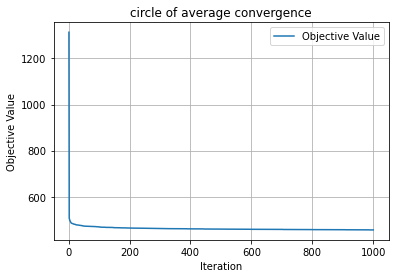

最佳解:  [46 11 45 50 26  0 31 10 37 15 49  8 48  4 36 43 14 44 32 38  9 29 33 20
 28  1 21  2 19 34 35 27 30 25  7 47 22  6 42 23 13 24 12 40 18 39 41 16
  3 17  5]
最佳值:  457.2444075965325
最佳平均解值 455.92493481931376


In [10]:
# main code

avg_val = 0
total_val = 0

# 紀錄每次採隨機移動迭代的值
run_history = []

for i in range(city_num):
    for j in range(city_num):
        if(i == j):
            distance_table[i][i] = 0
        else:
            # 存距離倒數
            distance_table[i][j] = 1 / getDistance(coordinate[i],coordinate[j])
            
# 隨機一組路徑解值
path = [i for i in range(city_num)]
# print(path)
init_distance = Evaluation(path)
# print(init_distance)

# 跑51次run平均1000次迭代
for i in range(run):
    # 新的一 run 先清空解暫存
    iteration_history = []

    # 初始化費洛蒙表
    pheromone_table = [[initial_pher for _ in range(city_num)] for _ in range(city_num)]
     
    # 紀錄最佳解及最佳值
    iter_bestdistance = init_distance
    iter_bestpath = [] #len + 1
    
    # 迭代 1000 次停止
    for k in range(iteration):
        
        # 螞蟻
        ants_bestdistance = init_distance
        ants_bestpath = [] #len + 1
        
        for ant in range(ants):
            
            # 利用費洛蒙和距離公式計算出單隻螞蟻的路徑 Transition: 產生一個解
            current_path = oneAntSolution()
            # Evaluation: 評估一個或多個解 目標值(Objective value)大小: 行徑總距離
            distance = Evaluation(current_path)
            # print("distance/ants_bestdistance: ", distance,"/",ants_bestdistance)
            # Determination: 儲存最佳解
            if (distance < ants_bestdistance):
                ants_bestdistance = distance
                ants_bestpath = current_path
                #print("ants_bestdistance: ", ants_bestdistance)
            
        # print("final ants_bestdistance: ", ants_bestdistance)
        # 更新費洛蒙:上次殘留的費洛蒙會隨時間蒸散 並 增加新產生的費洛蒙
        pheromone_table = pheromoneUpdate(pheromone_table, ants_bestdistance, ants_bestpath)
        # print("pheromone_table",pheromone_table)

        # 紀錄每次 iteration 值
        iteration_history.append(iter_bestdistance)
        # print("1/iter_bestdistance: ", iter_bestdistance) 
        
        if (ants_bestdistance < iter_bestdistance):
            # 儲存最佳解
            iter_bestdistance = ants_bestdistance
            iter_bestpath = ants_bestpath
            # print("iter_bestdistance: ", iter_bestdistance) 
        
    # 紀錄每 run 的下1000個 iteration值
    run_history.append(iteration_history)
    # print("run_history: ", run_history) 
    
# list 轉 np array 方便平均計算
val_history = np.array(run_history)

# 加總每一行
total_val = val_history.sum(axis=0)
# 跑 51次平均值
avg_val = total_val / run

# 畫採隨機移動的平均收斂圖
plotIteration(avg_val, iteration)
print("最佳解: ", iter_bestpath)
print("最佳值: " ,iter_bestdistance)
print("最佳平均解值",min(avg_val))  

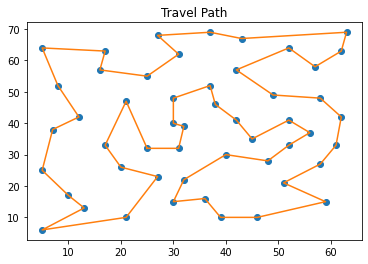

In [11]:
# 畫出路徑圖

x = [coordinate[i][0] for i in range(city_num)]
y = [coordinate[i][1] for i in range(city_num)]

path_X = []
path_Y = []

for i in iter_bestpath:
    path_X.append(coordinate[i][0])
    path_Y.append(coordinate[i][1])

# 回原點
path_X.append(coordinate[iter_bestpath[0]][0])
path_Y.append(coordinate[iter_bestpath[0]][1])

fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_title("Travel Path")
plt.plot(path_X,path_Y)
plt.show()